# Mini-Batch K-Means

1.Wygeneruj losową próbkę danych przy użyciu funkcji `sklearn.datasets.make_blobs`, w dalszych testach użyj tej funkcji kilkukrotnie, aby wygenerować kilka różnych przykładów.

2.Pogrupuj te dane przy użyciu klasycznego algorytmu K-Means z [tej strony](https://github.com/IS-UMK/datamining_tutorial/blob/master/kmeans.ipynb).

3.Zaimplementuj naiwną funkcje Mini-Batch K-Means. Naiwna oznacza odpalenie zwykłego K-Means na podzbiorach i sumowanie najbliższych klastrów (uśrednianie najbliższych centroidów).

4.Zaimplementuj funkcje Mini-Batch K-Means z _listingu_ poniżej, pochodzi z [tej pracy](https://dl.acm.org/doi/pdf/10.1145/1772690.1772862). Funkcja `f` opisana jest właśnie w tej pracy.

5.Porównaj czasy wykonania  wszystkich trzech metod, jak szybko zbiega współczynnik _inertia_ ? _Inertia_ lub wewnątrz grupowa suma kwadratów, jest to kryterium, które optymalizuje K-Means.

![Wzór](images/Wzór.png)

![Algorytm](images/Algorytm.png)

**Niezbędne biblioteki:**

In [1]:
from sklearn.datasets import make_blobs
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans

from numpy import linalg as LA
import numpy as np

from scipy.spatial import distance

import matplotlib.pyplot as plt

from random import randrange

from math import inf

import time

**Zdefiniowanie danych wstępnych** (ilości: centroidów, cech, próbek, iteracji; wylosowanie zbioru)**:**

In [2]:
k=4; # Ilość centroidów
features=k; # Ilość cech
samples=1000; # Ilość próbek
max_iters=100; # Ilość iteracji
batches=10; # Ilość kawałków

# Wymiary box'a dla wartości:
box_x = -10.0;
box_y = 10.0;

# Wylosowanie próbek:
#   x - wygenerowane próbki (wymiar: n_samples x n_features),
#   y - etykiety przynależności do danej klasy wybranej próbki.
x, y = make_blobs(n_samples=samples, n_features=features, centers=k, center_box=(box_x, box_y), random_state=0);

**Niezbędne funkcje** (Inertia, Batching)**:**

In [3]:
def Inertia(dists, indicies):
    result = 0;
    for i, dist in enumerate(dists):
        result = result + dist[indicies[i]];
    return result;

def Batching(samples, parts):
    batched_samples = np.split(samples, parts);
    return batched_samples;

**Algorytm K-Means na bazie [tego](https://github.com/IS-UMK/datamining_tutorial/blob/master/kmeans.ipynb) źródła:**

In [4]:
def K_Means(x, k, max_iters = 100, min_improvement=0.01):
    prev_dist = 0;
    
    while True:
        C = np.random.uniform(low=box_x, high=box_y, size=(k, features));
        dists = distance.cdist(x, C, metric='euclidean');
        s2id = np.argmin(dists, axis=1);
        if len(np.unique(s2id)) == k:
            break;
    
    for i in range(max_iters):
        dists = distance.cdist(x, C, metric='euclidean');
        s2id = np.argmin(dists, axis=1) ;
        curr_dist = np.mean(np.min(dists, axis=1));
    
        for j in range(len(C)):
            C[j] = np.mean(x[s2id==j], axis=0);
        
        if curr_dist - prev_dist < min_improvement:
            break;
        
        ine = Inertia(dists, s2id);
        K_Means_inertia.append(ine);
        #print("Współczynnik inertia:", ine);

    return s2id, C;

**Pogrupowanie danych z użycie algorytmu K-Means [stąd](https://github.com/IS-UMK/datamining_tutorial/blob/master/kmeans.ipynb).**

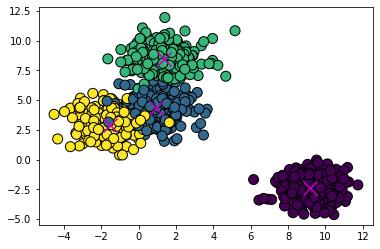

In [5]:
K_Means_inertia = [];

# Wykorzystanie K-Means:
start = time.time();
s2id, C = K_Means(x, k=k, max_iters=max_iters);
end = time.time();

K_Means_time = end - start;

# Konfiguracja rozmiaru wykresu:
#plt.figure(figsize=(18, 16), dpi=80);

# Wyrysowanie próbek wraz z centrami:
plt.scatter(x[:, 0], x[:, 1], marker='o', s=100, c = s2id, edgecolor='k');
plt.scatter(C.T[0], C.T[1], s=200, marker='x', c='m');

# Zapis do obrazka:
plt.savefig('Classic_K-Means.png');

**Implementacja naiwnego K-Means (zwykły K-Means na podzbiorach z sumowaniem najbliższych klastrów - uśrednianiem najbliższych centroidów):**

In [6]:
def Summarize(C, k, capacity):
    new_C = [];
    
    for i in range(k):
        center = [];
        
        for j in range(len(C)):
            center.append(C[j][i]);
        
        center = np.concatenate(center, axis=0);
        np.asmatrix(center);
        center.shape = (capacity, k);
        
        new_C.append(center.mean(0));
    
    new_C = np.array(new_C);
    return new_C;


def FeatureSorting(dataset):
    
    for i in range(len(dataset)):
        c = dataset[i];
        sorted = c[np.argsort(c[:,0])];
        dataset[i] = sorted;
    
    return dataset;


def K_Means_Naive(dataset, batches, k, max_iters, capacity):
    n = len(batches);
    s2ids = [];
    C = [];
    
    for i in range(n):
        batch = batches[i];
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, random_state=0).fit(batch);
        s2ids.append(kmeans.labels_);
        C.append(kmeans.cluster_centers_);
        
        K_Means_Naive_inertia.append(kmeans.inertia_);
        #print("Współczynnik inertia:", kmeans.inertia_);
        
    C = FeatureSorting(C);
    new_C = Summarize(C, k, capacity);
    return s2ids, C, new_C;

**Pogrupowanie danych z użycie algorytmu Naiwnego K-Means:**

In [7]:
batched = Batching(x, batches);

K_Means_Naive_inertia = [];

start = time.time();
s2ids, C, new_C = K_Means_Naive(x, batched, k, max_iters, batches);
end = time.time();

K_Means_Naive_time = end - start;

**Wynik Naiwnego K-Means przed uśrednianiem centrów:**

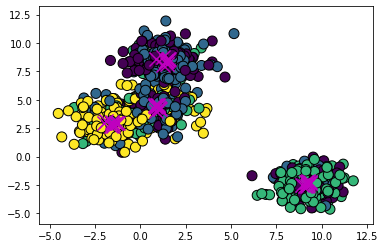

In [8]:
# Konfiguracja rozmiaru wykresu:
#plt.figure(figsize=(18, 16), dpi=80);

for i in range(len(batched)):
    plt.scatter(batched[i].T[0], batched[i].T[1], marker='o', s=100, c = s2ids[i], edgecolor='k');
for i in range(len(C)):
    plt.scatter(C[i].T[0], C[i].T[1], s=200, marker='x', c='m');

**Uśrednianie centrów:**

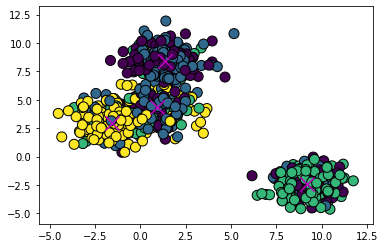

In [9]:
# Konfiguracja rozmiaru wykresu:
#plt.figure(figsize=(18, 16), dpi=80);

for i in range(len(batched)):
    plt.scatter(batched[i].T[0], batched[i].T[1], marker='o', s=100, c = s2ids[i], edgecolor='k');

for i in range(len(new_C)):
    plt.scatter(new_C[i].T[0], new_C[i].T[1], s=200, marker='x', c='m');

**Po uśrednieniu wszystkich centrów:**

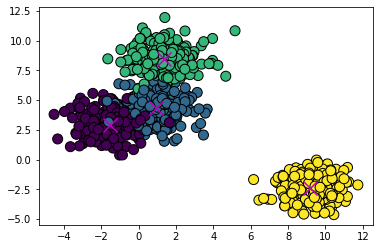

In [10]:
dists = distance.cdist(x, new_C, metric='euclidean');
x_result = np.argmin(dists, axis=1);

# Konfiguracja rozmiaru wykresu:
#plt.figure(figsize=(18, 16), dpi=80);

plt.scatter(x.T[0], x.T[1], marker='o', s=100, c = x_result, edgecolor='k');
plt.scatter(new_C.T[0], new_C.T[1], s=200, marker='x', c='m');

plt.savefig('Naive_K-Means.png');

**Mini-Batch K-Means [stąd](https://dl.acm.org/doi/pdf/10.1145/1772690.1772862):**

In [11]:
def Comparing(L, x):
    for l in L:
        if (l == x).all():
            return True;
    return False;

def K_Means_MiniBatch(dataset, k, batch_size, t):
    C = dataset[np.random.permutation(dataset.shape[0])[:k]];
    for i in range(t):
        M = dataset[np.random.permutation(dataset.shape[0])[:batch_size]];
        d = {};
        v = np.zeros(C.shape[0]);
        d = np.empty(M.shape[0], dtype=np.int);
        for j, x in enumerate(M):
            d[j] = np.argmin(((C - x)**2).sum(1));
        for j, x in enumerate(M):
            v[d[j]] = v[d[j]] + 1;
            learning_rate = 1.0 / v[d[j]];
            C[d[j]] = (1.0 - learning_rate) * C[d[j]] + learning_rate * x;
        
        dists = distance.cdist(dataset, C, metric='euclidean');
        s2id = np.argmin(dists, axis=1);
        ine = Inertia(dists, s2id);
        K_Means_MiniBatch_inertia.append(ine);
        #print("Inertia: %s" % Inertia(dists, s2id));
    tree = KDTree(C);
    labels = tree.query(dataset, k=1, return_distance=False).squeeze();
    return C, labels;

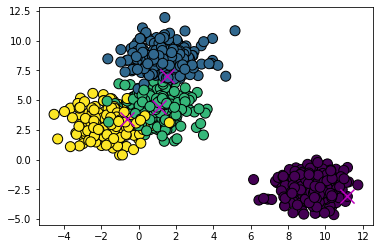

In [12]:
K_Means_MiniBatch_inertia = [];

start = time.time();
centers, labels = K_Means_MiniBatch(x, k, batches, max_iters);
end = time.time();

K_Means_MiniBatch_time = end - start;

plt.scatter(x.T[0], x.T[1], marker='o', s=100, c = labels, edgecolor='k');
for i in range(len(new_C)):
    plt.scatter(centers[i].T[0], centers[i].T[1], s=200, marker='x', c='m');

plt.savefig('MiniBatch_K-Means.png');

**Wykresy z czasami wszystkich trzech metod:**

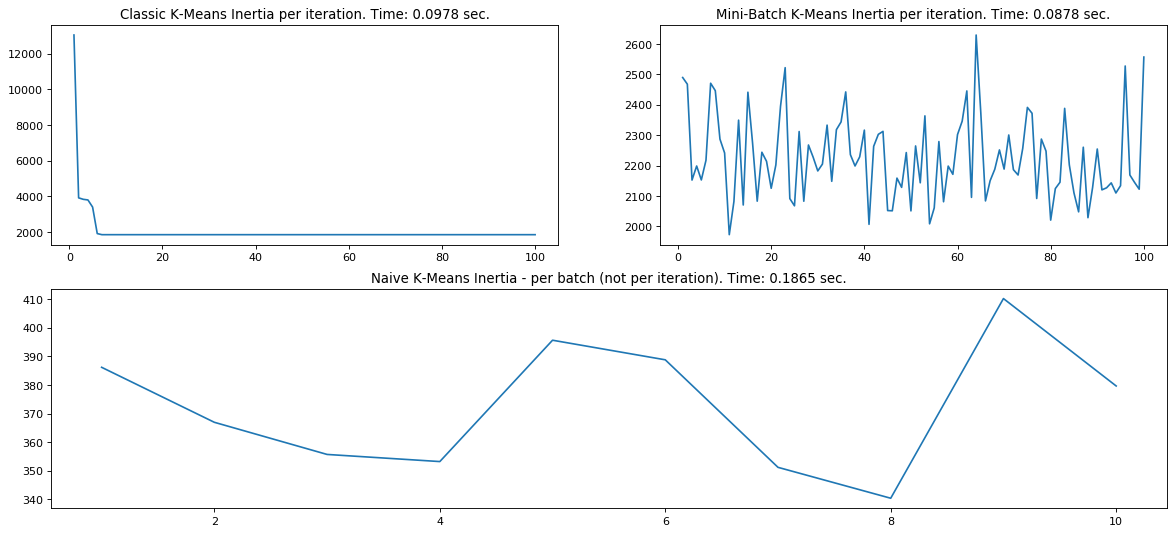

In [13]:
t1 = np.arange(start=1, stop=(max_iters+1), step=1);
t2 = np.arange(start=1, stop=(batches+1), step=1);

plt.figure(figsize=(18, 8), dpi=80);

ax1 = plt.subplot(221);
ax1.set_title('Classic K-Means Inertia per iteration. Time: ' + str(round(K_Means_time, 4)) + ' sec.');
plt.plot(t1, K_Means_inertia);

ax2 = plt.subplot(222);
ax2.set_title('Mini-Batch K-Means Inertia per iteration. Time: ' + str(round(K_Means_MiniBatch_time, 4)) + ' sec.');
plt.plot(t1, K_Means_MiniBatch_inertia);

ax3 = plt.subplot(212);
ax3.set_title('Naive K-Means Inertia - per batch (not per iteration). Time: ' + str(round(K_Means_Naive_time, 4)) + ' sec.');
plt.plot(t2, K_Means_Naive_inertia);